In [1]:
# ===============================================================================================================#
#
# Copyright 2021 Infosys Ltd.
# Use of this source code is governed by Apache License Version 2.0 that can be found in the LICENSE file or at
# http://www.apache.org/licenses/
#
# ===============================================================================================================#

## 1. Preparation

In [2]:
import json
from libraries._internal_utils.demo_helper import DemoHelper
import pandas as pd
from IPython.display import Image

#### <span style='color:blue'>Enter image and OCR file paths</span>

In [3]:
IMAGE_PATH="./data/text.png"
IMAGE_OCR_PATH='./data/text.hocr'
TEMP_FOLDER_PATH = './data/temp'

#### Visualize

In [4]:
IMAGE_PATHS=[IMAGE_PATH]
tab_widget = DemoHelper.create_tab_toolbar(IMAGE_PATHS)
display(tab_widget)
for idx, image_path in enumerate(IMAGE_PATHS):
    with tab_widget.children[idx]:
        display(Image(filename=image_path, width=800, height=50))

## 2. Initialization

#### <span style='color:blue'>Create new instance with desired OCR service provider</span>

In [5]:
from infy_field_extractor import text_extractor
from infy_ocr_parser import ocr_parser
from infy_field_extractor.providers.ocr_data_service_provider import OcrDataServiceProvider
from infy_ocr_parser.providers.tesseract_ocr_data_service_provider import TesseractOcrDataServiceProvider
from infy_ocr_parser.providers.azure_read_ocr_data_service_provider import AzureReadOcrDataServiceProvider
import logging
import os

if not os.path.exists('./logs'):
    os.makedirs('./logs')

if not os.path.exists(TEMP_FOLDER_PATH):
    os.makedirs(TEMP_FOLDER_PATH)    
    
logging.basicConfig(filename=('./logs' + '/app_log.log'),
                format='%(asctime)s- %(levelname)s- %(message)s',
                level=logging.CRITICAL, datefmt='%d-%b-%y %H:%M:%S')
logger = logging.getLogger() 
logger.info('log initialized')

# Uncomment below for Tesseract OCR service
data_service_provider_obj = TesseractOcrDataServiceProvider()
# Uncomment below for Azure OCR Read service
# data_service_provider_obj = AzureReadOcrDataServiceProvider()

ocr_parser_object = ocr_parser.OcrParser(ocr_file_list=[IMAGE_OCR_PATH],
                                         data_service_provider=data_service_provider_obj)
provider = OcrDataServiceProvider(ocr_parser_object)
    
text_obj = text_extractor.TextExtractor(provider,provider,temp_folderpath=TEMP_FOLDER_PATH, 
        logger = None, debug_mode_check = False)

2022-04-03 20:07:24,402.402 INFO [MainThread] [data_service_provider_interface] [__set_logger:114] log initialized
2022-04-03 20:07:24,413.413 INFO [MainThread] [data_service_provider_interface] [__set_logger:145] log initialized
2022-04-03 20:07:24,414.414 INFO [MainThread] [text_extractor] [__init__:96] log initialized


## 3. API - extract_custom_fields()

### 3.1. Example

In this example "field_key" and "field_value_pos" is required. It searches for the "field_key" in the image using ocr_parser_obj and extract the nearest text as value to the "field_key" in the direction given by the param "field_value_pos". If "field_state_pos" not given, it dynamically searches the nearest value in all the direction and extracts it.

In [6]:
text_field_data_list = [
    {
        "field_key": [
            "Family Name:"
        ]
    },
    {
        "field_key": [
            "Given Name:"
        ],
        "field_value_pos": "right"
    }
]

output = text_obj.extract_custom_fields(image_path = IMAGE_PATH,
                                        text_field_data_list =text_field_data_list)

#### Output

In [7]:
# print(json.dumps(output, indent=4))
df = pd.json_normalize(output['fields'])
print('No. of records found =', len(df))
df

No. of records found = 2


,field_key,field_value,error
0,[Family Name:],Heck,None
1,[Given Name:],Lillian B,None


### 3.2. Example
In this example "field_state_bbox" is required and "field_key" is optional. For each element in the text_field_data_list, it finds the text within the region given by the "field_state_bbox" param and extracts as its value.

In [8]:
text_field_data_list =[
    {
        "field_key": [
            "Family Name:"
        ],
        "field_value_bbox": [
            1140,
            153,
            1471,
            163
        ]
    },
    {
        "field_key": [
            "Given Name:"
        ],
        "field_value_bbox": [
            1140,
            461,
            1471,
            163
        ]
    }
]

output = text_obj.extract_custom_fields(image_path = IMAGE_PATH,
                                        text_field_data_list =text_field_data_list)

#### Output

In [9]:
# print(json.dumps(output, indent=4))
df = pd.json_normalize(output['fields'])
print('No. of records found =', len(df))
df

No. of records found = 2


,field_key,field_value_bbox,field_value
0,[Family Name:],"[1140, 153, 1471, 163]",Lillian B
1,[Given Name:],"[1140, 461, 1471, 163]",Heck


#### Visualize

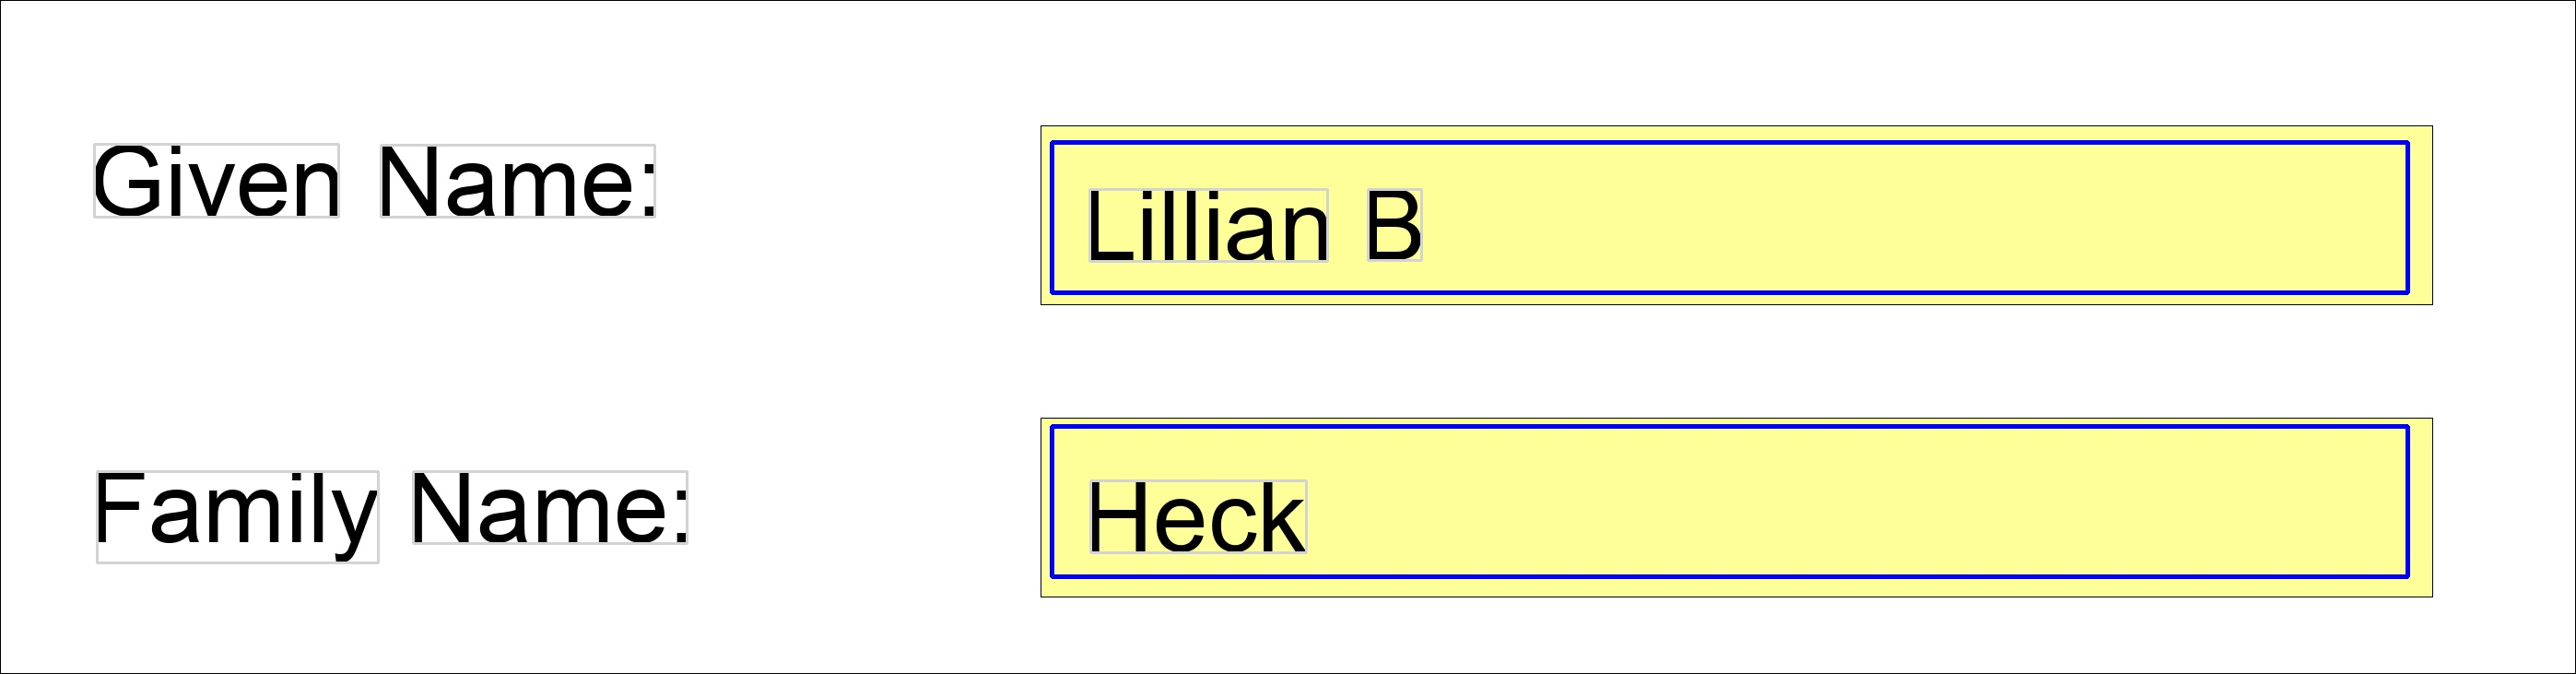

In [10]:
# Get all tokens i.e. without any bounding box restrictions
all_tokens = ocr_parser_object.get_tokens_from_ocr(
    token_type_value=1,     
    pages=[1]
)
all_tokens_text_bboxes = [x['bbox'] for x in all_tokens]

field_state_bboxes = [x['field_value_bbox'] for x in text_field_data_list]
all_bboxes = field_state_bboxes 
img = DemoHelper.read_image(IMAGE_PATH)
img = DemoHelper.draw_bboxes_on_image(img, all_tokens_text_bboxes, border_thickness=2, 
                                         border_color = DemoHelper.Constants.COLOR_GRAY)
img = DemoHelper.draw_bboxes_on_image(img, field_state_bboxes, border_thickness=4,
                                         border_color = DemoHelper.Constants.COLOR_BLUE)
img = DemoHelper.reduce_image_based_on_context(img, all_bboxes)

DemoHelper.show_image(img)

## 4. API - extract_all_fields()

Extracts key-value pairs dynamically assuming value is to the right of key

### 4.1. Example

In [11]:
output = text_obj.extract_all_fields(image_path = IMAGE_PATH)

2022-04-03 20:07:24,642.642 WARNING [MainThread] [extractor_helper] [check_image_dpi:287] The result might be not accurate due to low dpi


C:\Users\mohan_sundararaju\.virtualenvs\notebook-VJ1UQSNq\lib\site-packages\infy_field_extractor\internal\extractor_helper.py:286: UserWarning: The result might be not accurate due to low dpi
  warnings.warn(warning)


#### Output

In [12]:
# print(json.dumps(output, indent=4))
df = pd.json_normalize(output['fields']).T
print('No. of records found =', len(df))
df

No. of records found = 2


,0
Family Name:,Heck
Given Name:,Lillian B
